# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1b. Load the data
Call the variable `cigData`. 

In [3]:
cigData = pd.read_csv('CowboyCigsData.csv', index_col=0)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [4]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.shape

(144, 2)

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Time         object
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isna().sum()

Time         0
#CigSales    0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

<font color=red> Unnecessary, since already removed when reading 

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cigData = cigData.rename({'Time':'Month'}, axis=1)

Call a head() to check this has worked. 

In [9]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

In [11]:
cigData = cigData.set_index('Month')

In [12]:
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #CigSales column. 

In [13]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [14]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [15]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

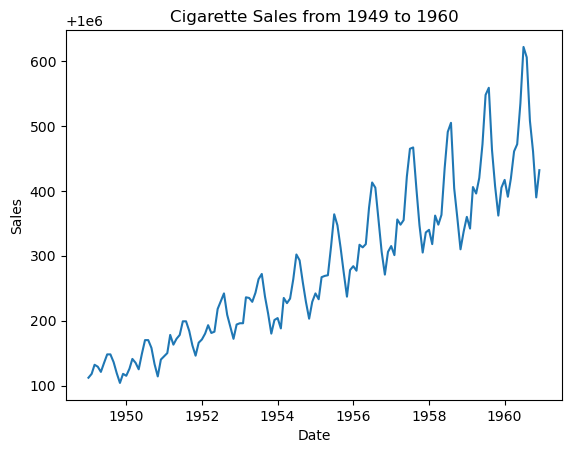

In [16]:
plt.title('Cigarette Sales from 1949 to 1960')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(y);

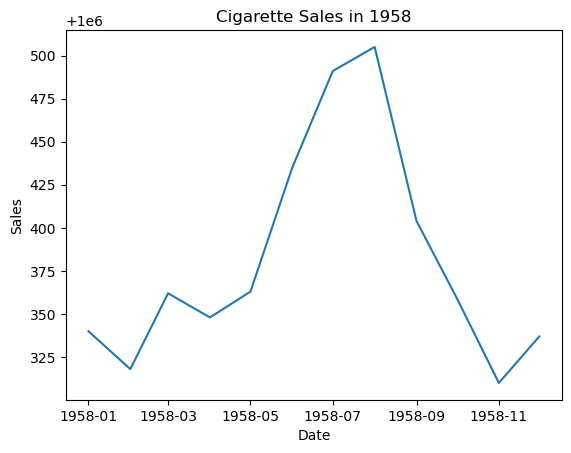

In [17]:
y_1958 = cigData.loc['1958']
plt.title('Cigarette Sales in 1958')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(y_1958);

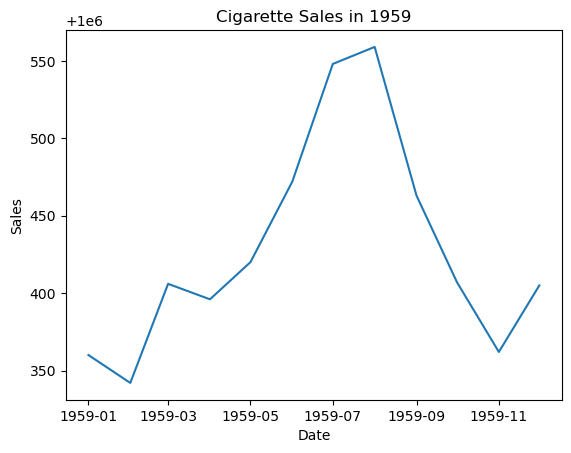

In [18]:
y_1959 = cigData.loc['1959']
plt.title('Cigarette Sales in 1959')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(y_1959);

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

<font color=red> It is a non-stationary series with seasonality.</font>

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

<font color=red> Based on the sales in 1958 and 1959, we can find the sale increase with temperature increase and decrease with temperature decrease. That means Smoking habits can be influenced by weather conditions. For example, during the winter, people may be less inclined to smoke outdoors due to the cold, which could lead to a temporary decrease in cigarette sales.</font> 

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

multiplicative

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [19]:
import statsmodels.api as sm
decompose = sm.tsa.seasonal_decompose(y, model='multiplicative')

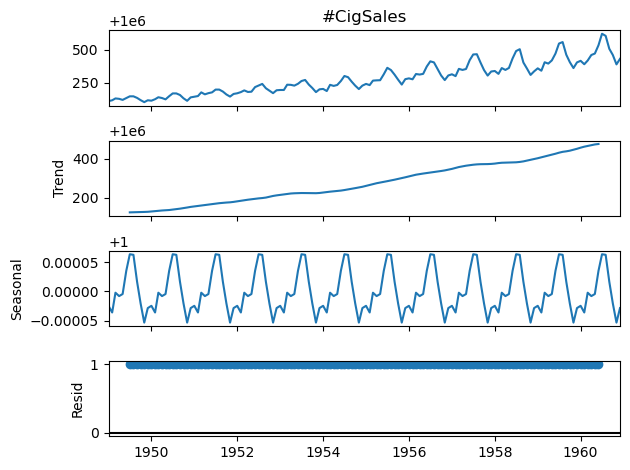

In [20]:
# Plot the original data, the trend, the seasonality, and the residuals 
decompose.plot();

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. <font color=red>A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.</font>

There are many ways to test for stationarity, but one of the most common is the KPSS test. <font color=red>The Null hypothesis of this test is that the time series data in question is stationary;</font> hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [21]:
from statsmodels.tsa.stattools import kpss

In [22]:
print("Null hypothesis: the sale data is stationary")
print(f"the p-value for KPSS test is {kpss(y)[1]}")

Null hypothesis: the sale data is stationary
the p-value for KPSS test is 0.01


/var/folders/q3/bh77rs4j287b2164gqnr73h40000gn/T/ipykernel_48537/4029717707.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f"the p-value for KPSS test is {kpss(y)[1]}")


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

In [23]:
y.head()

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: #CigSales, dtype: int64

<font color=red>In our plot, we can see that both the mean and the variance *increase as time progresses*.</font> At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [24]:
y_log = np.log(y)

In [25]:
y_log.head()

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
Name: #CigSales, dtype: float64


When you plot this, you can see how the variance in our data now remains contant over time.

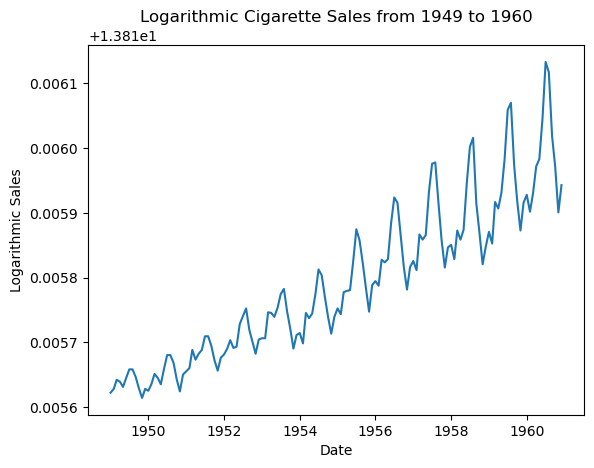

In [26]:
plt.title('Logarithmic Cigarette Sales from 1949 to 1960')
plt.xlabel('Date')
plt.ylabel('Logarithmic Sales')
plt.plot(y_log);

We now have a constant variance, but we also need a constant mean. <font color=red>But the plot looks same as previous one.</font>

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [27]:
y_log.diff()

Month
1949-01-01         NaN
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
                ...   
1960-08-01   -0.000016
1960-09-01   -0.000098
1960-10-01   -0.000047
1960-11-01   -0.000071
1960-12-01    0.000042
Name: #CigSales, Length: 144, dtype: float64

In [28]:
print("Null hypothesis: the logarithmic sale data is stationary")
print(f"the p-value for KPSS test is {kpss(y_log)[1]}")

Null hypothesis: the logarithmic sale data is stationary
the p-value for KPSS test is 0.01


/var/folders/q3/bh77rs4j287b2164gqnr73h40000gn/T/ipykernel_48537/3247734821.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f"the p-value for KPSS test is {kpss(y_log)[1]}")


In [29]:
print("Null hypothesis: the change of logarithmic sale data is stationary")
print(f"the p-value for KPSS test is {kpss(y_log.diff().dropna())[1]}")

Null hypothesis: the change of logarithmic sale data is stationary
the p-value for KPSS test is 0.1


/var/folders/q3/bh77rs4j287b2164gqnr73h40000gn/T/ipykernel_48537/2852167143.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"the p-value for KPSS test is {kpss(y_log.diff().dropna())[1]}")


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary. Actually, we CANNOT REJECT!!!

what it looks like???

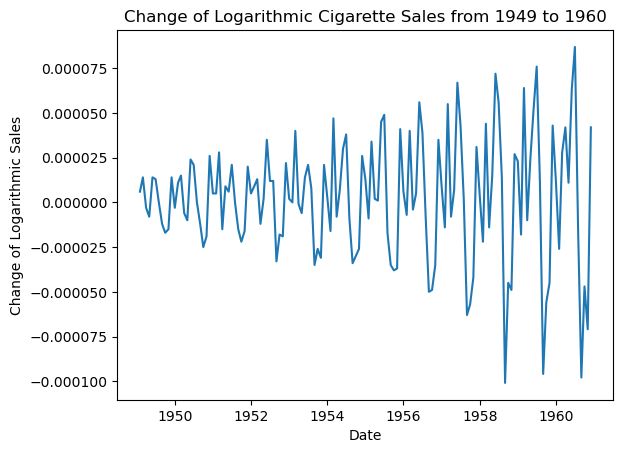

In [30]:
plt.title('Change of Logarithmic Cigarette Sales from 1949 to 1960')
plt.xlabel('Date')
plt.ylabel('Change of Logarithmic Sales')
plt.plot(y_log.diff().dropna());

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [31]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [32]:
def evaluation(data, order):
    split=int(len(data) * 0.8) 
    train, test = data.values[0:split], data.values[split:len(data)]       # Time series train_test_split must like this....
    final_predict=[]
    for i in range(len(test)):
        model = ARIMA(train, order=order)
        res = model.fit()
        predict = res.forecast()
        final_predict.append(predict)
        train = np.append(train, test[i])
    return mean_squared_error(test, final_predict)


#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [33]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluation_pdq(data, pvalues,dvalues,qvalues):
    result = {}
    for p in pvalues:
        for d in dvalues:
            for q in qvalues:
                order = (p,d,q)
                mse = evaluation(data, order)
                result[order]=mse
    return result

In [34]:
# Now, we choose a couple of values to try for each parameter.
pvalues = [0,1,2]
dvalues = [0,1,2]
qvalues = [0,1,2]

In [35]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
result = evaluation_pdq(y_log, pvalues=pvalues, dvalues=dvalues, qvalues=qvalues)
sorted_result = dict(sorted(result.items(), key=lambda x: x[1]))
print(f"The best (p,d,q) is {list(sorted_result.keys())[0]}")
print(f"The corresponding MSE is {list(sorted_result.values())[0]}")

/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

The best (p,d,q) is (2, 1, 1)
The corresponding MSE is 2.2522549152349057e-09


### <font color=red>is the mse metric for selecting p,d,q? 

### <font color=red>why evaluate y_log not y_log.diff()? 

### <font color=red>based on KPSS test, y_log is NOT stationary. y_log.diff() is stationary

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [36]:
y_log

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
                ...    
1960-08-01    13.816116
1960-09-01    13.816018
1960-10-01    13.815971
1960-11-01    13.815900
1960-12-01    13.815942
Name: #CigSales, Length: 144, dtype: float64

In [37]:
p=2
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
result = model.fit()
predict = result.predict()

/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
predict

1949-01-01     0.000000
1949-02-01    13.815623
1949-03-01    13.815630
1949-04-01    13.815644
1949-05-01    13.815637
                ...    
1960-08-01    13.816143
1960-09-01    13.816082
1960-10-01    13.815968
1960-11-01    13.815961
1960-12-01    13.815891
Freq: MS, Name: predicted_mean, Length: 144, dtype: float64

We can take a look at a summary of the model this library has built around our data.

In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1287.245
Date:                Fri, 15 Dec 2023   AIC                          -2566.490
Time:                        12:18:53   BIC                          -2554.639
Sample:                    01-01-1949   HQIC                         -2561.674
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575   1.33e-19   7.98e+18      0.000       1.057       1.057
ar.L2         -0.4391   7.17e-19  -6.12e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.89e-20  -1.82e+19      0.000      -0.708      -0.708
sigma2      7.158e-10   2.65e-10      2.705      0.007    1.97e-10    1.23e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.40   Prob(JB):                         0.73
Heteroskedasticity (H):               7.95   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.88e+45. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

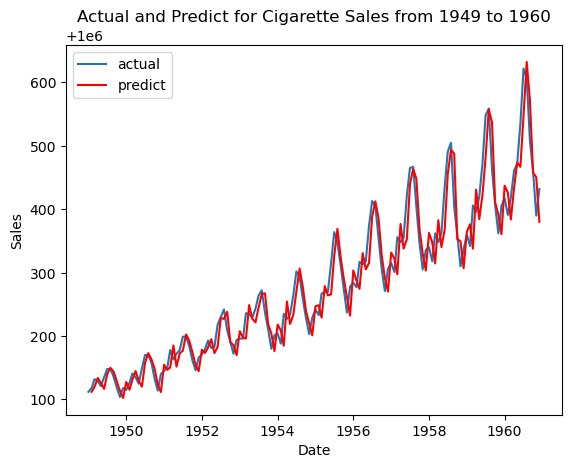

In [40]:
plt.plot(y)
plt.plot(np.exp(predict[1:]), color = 'red')
plt.legend(['actual','predict'])
plt.title('Actual and Predict for Cigarette Sales from 1949 to 1960')
plt.xlabel('Date')
plt.ylabel('Sales');

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [44]:
forecast = np.exp(result.forecast(24))
forecast = pd.concat([y[[-1]], forecast])

In [45]:
forecast

1960-12-01    1.000432e+06
1961-01-01    1.000468e+06
1961-02-01    1.000489e+06
1961-03-01    1.000496e+06
1961-04-01    1.000493e+06
1961-05-01    1.000487e+06
1961-06-01    1.000483e+06
1961-07-01    1.000480e+06
1961-08-01    1.000480e+06
1961-09-01    1.000480e+06
1961-10-01    1.000481e+06
1961-11-01    1.000481e+06
1961-12-01    1.000482e+06
1962-01-01    1.000482e+06
1962-02-01    1.000482e+06
1962-03-01    1.000482e+06
1962-04-01    1.000482e+06
1962-05-01    1.000481e+06
1962-06-01    1.000481e+06
1962-07-01    1.000481e+06
1962-08-01    1.000482e+06
1962-09-01    1.000482e+06
1962-10-01    1.000482e+06
1962-11-01    1.000482e+06
1962-12-01    1.000482e+06
dtype: float64

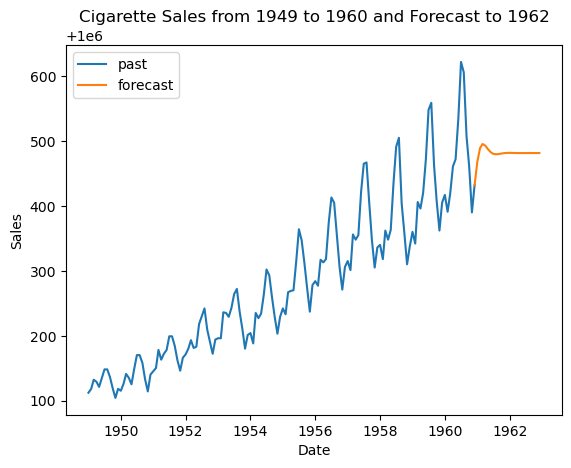

In [47]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
# Convert that range into a dataframe that includes your predictions
# Plot your future predictions
plt.plot(y, label='past')
plt.plot(forecast, label='forecast')
plt.title('Cigarette Sales from 1949 to 1960 and Forecast to 1962')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### <font color=red>try use Akaike Information Criterion (AIC) to evaluate models

In [356]:
def evaluation_pdq_aic (data, pvalues, dvalues, qvalues):
    result = {}
    for p in pvalues:
        for d in dvalues:
            for q in qvalues:
                order = (p,d,q)
                model = ARIMA(data, order=order)
                res = model.fit()
                result[order]=res.aic
    return result

In [50]:
y_log_change = y_log.diff().dropna()

In [358]:
result_change = evaluation_pdq_aic(y_log_change, pvalues=pvalues, dvalues=dvalues, qvalues=qvalues)
sorted_result_change = dict(sorted(result_change.items(), key=lambda x: x[1]))
print(f"The best (p,d,q) is {list(sorted_result_change.keys())[0]}")
print(f"The corresponding aic is {list(sorted_result_change.values())[0]}")

The best (p,d,q) is (2, 0, 1)
The corresponding aic is -2565.8575162908837


In [53]:
p=2
d=0
q=1
model = ARIMA(y_log_change, order=(p,d,q))
result = model.fit()
predict = result.predict()

/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lilyma/anaconda3/envs/base_mostly_used/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
predict

1949-02-01    0.000001
1949-03-01    0.000003
1949-04-01    0.000006
1949-05-01   -0.000003
1949-06-01   -0.000003
                ...   
1960-08-01    0.000013
1960-09-01   -0.000034
1960-10-01   -0.000051
1960-11-01   -0.000009
1960-12-01   -0.000009
Freq: MS, Name: predicted_mean, Length: 143, dtype: float64

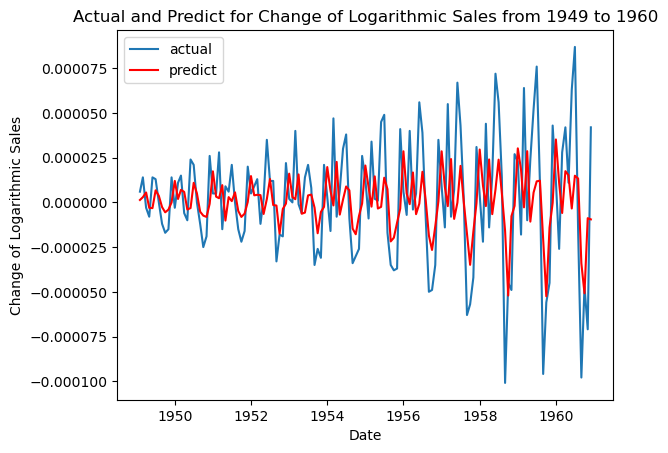

In [361]:
plt.plot(y_log_change)
plt.plot(predict, color = 'red')
plt.legend(['actual','predict'])
plt.title('Actual and Predict for Change of Logarithmic Sales from 1949 to 1960')
plt.xlabel('Date')
plt.ylabel('Change of Logarithmic Sales');

<font color=red>is the above fit good?????

In [55]:
forecast = result.forecast(24)
forecast[0] = forecast[0]+y_log.iloc[-1]
forecast = forecast.cumsum()        # use cumsum() to return back to log sale
forecast = pd.concat([y_log[[-1]], forecast])
forecast

1960-12-01    13.815942
1961-01-01    13.815982
1961-02-01    13.816006
1961-03-01    13.816015
1961-04-01    13.816014
1961-05-01    13.816010
1961-06-01    13.816006
1961-07-01    13.816004
1961-08-01    13.816005
1961-09-01    13.816007
1961-10-01    13.816009
1961-11-01    13.816011
1961-12-01    13.816013
1962-01-01    13.816014
1962-02-01    13.816015
1962-03-01    13.816017
1962-04-01    13.816018
1962-05-01    13.816019
1962-06-01    13.816021
1962-07-01    13.816022
1962-08-01    13.816023
1962-09-01    13.816025
1962-10-01    13.816026
1962-11-01    13.816027
1962-12-01    13.816029
dtype: float64

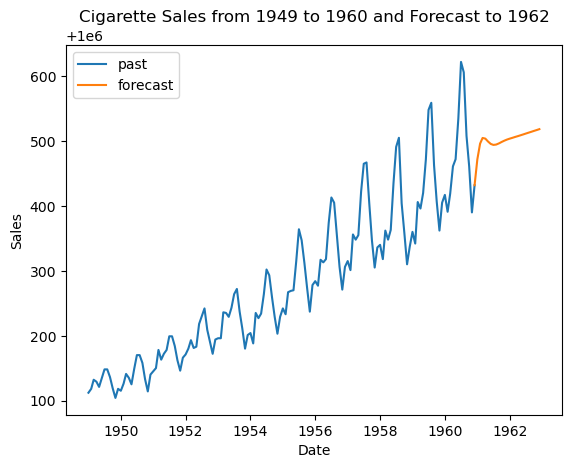

In [56]:
plt.plot(y, label='past')
plt.plot(np.exp(forecast), label='forecast')
plt.title('Cigarette Sales from 1949 to 1960 and Forecast to 1962')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<font color=red>which one is better for forecast????

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 